# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [26]:
import torch
import torch.nn.functional as F         # 대문자임을 주의하기 바랍니다.   
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os
import copy

## GPU 설정

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

## 데이터 로드 및 확인

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d.

## 전처리 설정

In [16]:
data_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   
                   'val' : transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [53]:
data_dir = './hymenoptera_data'
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                  for x in ['train', 'val']}

dataloader = {x : DataLoader(image_datasets[x],
                             batch_size = 4,
                             shuffle = True,
                             num_workers =4) for x in ['train', 'val']}


dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [19]:
model_ft = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [ ]:
model_ft

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [54]:
num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, 2)

mode_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [55]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [29]:
# gamma 만큼 learning_rate 를 간단하게 줄여줍니다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

## 모델 학습

- 학습 함수 정의

In [56]:
def train_model(model, criterion, optimizer, scheduler, num_epoch = 25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch, num_epoch - 1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0


      for inputs,labels in dataloader[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # phase 가 train인 경우에만 set_grad를 실행 시켜줘야 합니다.
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predicted == labels.data)

      if phase == 'train':
        scheduler.step()

      
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss : {:.4f}\tAccuracy : {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_models_wts = copy.deepcopy(model.state_dict())
    
    print()
  
  time_elapse = time.time() - since
  print('Training Time : {:.0f}m {:0f}s'.format(time_elapse // 60, time_elapse % 60))
  print('Best Validation Accuract : {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [57]:
model_ft = train_model(model_ft,criterion, optimizer_ft, exp_lr_scheduler, 25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss : 0.5252	Accuracy : 0.7418


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss : 0.2210	Accuracy : 0.9346

Epoch 1/24
----------
train Loss : 0.4684	Accuracy : 0.7869
val Loss : 0.5321	Accuracy : 0.7582

Epoch 2/24
----------
train Loss : 0.7143	Accuracy : 0.7336
val Loss : 0.3809	Accuracy : 0.8562

Epoch 3/24
----------
train Loss : 0.5934	Accuracy : 0.7828
val Loss : 1.1304	Accuracy : 0.7582

Epoch 4/24
----------
train Loss : 0.7731	Accuracy : 0.7582
val Loss : 0.7274	Accuracy : 0.8497

Epoch 5/24
----------
train Loss : 0.7068	Accuracy : 0.7787
val Loss : 0.2772	Accuracy : 0.9150

Epoch 6/24
----------
train Loss : 0.4960	Accuracy : 0.7664
val Loss : 0.3879	Accuracy : 0.8366

Epoch 7/24
----------
train Loss : 0.3799	Accuracy : 0.8361
val Loss : 0.3851	Accuracy : 0.8758

Epoch 8/24
----------
train Loss : 0.3672	Accuracy : 0.8648
val Loss : 0.5002	Accuracy : 0.8366

Epoch 9/24
----------
train Loss : 0.4581	Accuracy : 0.8443
val Loss : 0.3361	Accuracy : 0.8954

Epoch 10/24
----------
train Loss : 0.4511	Accuracy : 0.8279
val Loss : 0.2812	Accuracy : 

## 결과 시각화

- 시각화 함수 정의

In [58]:
def imshow(img):
  img = img / 2 + 0.5
  nping = img.numpy()
  fig = plt.figure(figsize =(10, 5))
  plt.imshow(np.transpose(nping, (1, 2, 0)))
  plt.show()

In [66]:
def visualize_model(model, num_images = 6):
  was_trainig = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i , (inputs, labels) in enumerate(dataloader['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)


      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted : {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode = was_trainig)
          return
      
      model.train(mode = was_trainig)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


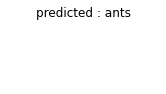

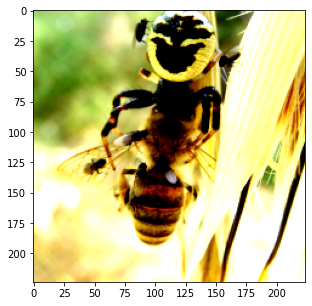

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


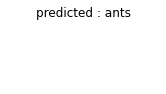

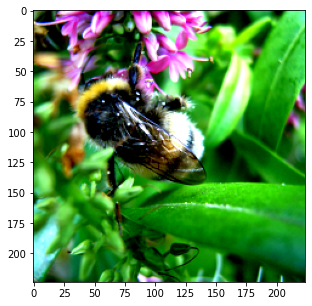

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


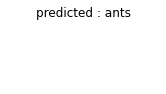

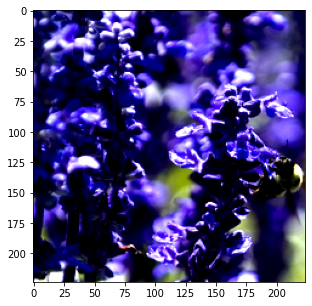

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


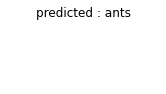

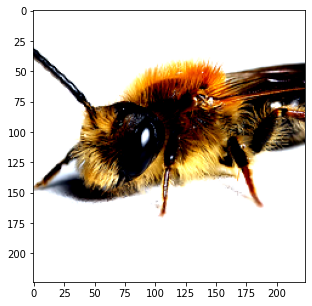

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


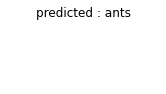

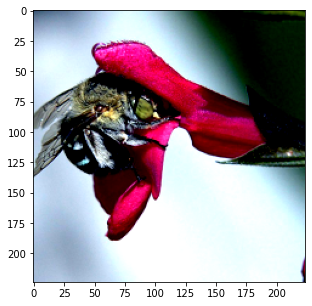

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


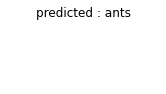

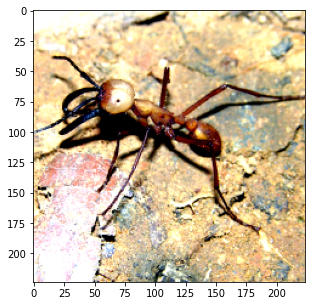

In [67]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [71]:
model_conv = torchvision.models.resnet18(pretrained = True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr = 0.001, momentum= 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma = 0.1)

In [72]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, 25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss : 0.5566	Accuracy : 0.7295
val Loss : 0.2321	Accuracy : 0.9346

Epoch 1/24
----------
train Loss : 0.5243	Accuracy : 0.7541
val Loss : 0.3642	Accuracy : 0.8627

Epoch 2/24
----------
train Loss : 0.5515	Accuracy : 0.7910
val Loss : 0.2428	Accuracy : 0.9346

Epoch 3/24
----------
train Loss : 0.4654	Accuracy : 0.8033
val Loss : 0.2140	Accuracy : 0.9477

Epoch 4/24
----------
train Loss : 0.4705	Accuracy : 0.7992
val Loss : 0.3342	Accuracy : 0.8824

Epoch 5/24
----------
train Loss : 0.5666	Accuracy : 0.7541
val Loss : 0.2626	Accuracy : 0.9020

Epoch 6/24
----------
train Loss : 0.3887	Accuracy : 0.8443
val Loss : 0.2511	Accuracy : 0.9150

Epoch 7/24
----------
train Loss : 0.3960	Accuracy : 0.8279
val Loss : 0.1925	Accuracy : 0.9542

Epoch 8/24
----------
train Loss : 0.3516	Accuracy : 0.8484
val Loss : 0.1886	Accuracy : 0.9477

Epoch 9/24
----------
train Loss : 0.3696	Accuracy : 0.8279
val Loss : 0.1773	Accuracy : 0.9477

Epoch 10/24
----------
train Loss : 0.3389	Accuracy 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


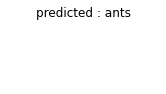

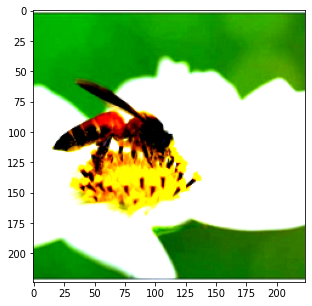

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


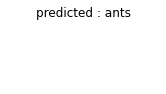

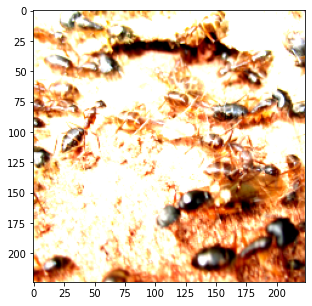

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


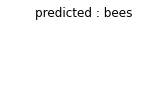

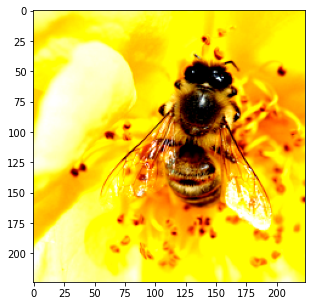

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


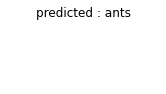

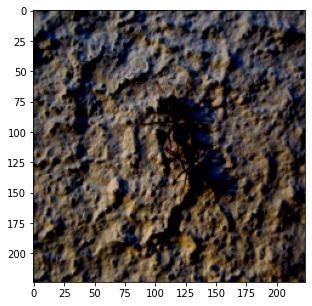

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


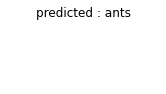

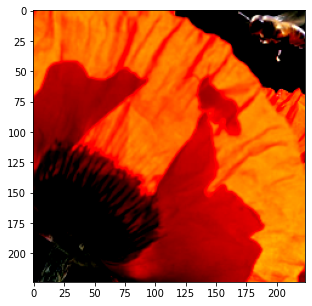

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


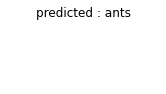

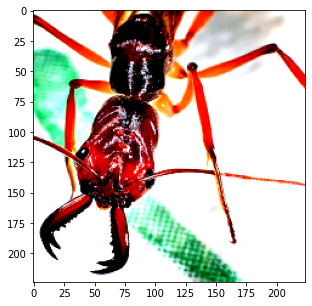

In [73]:
visualize_model(model_conv)